# Neural Network

In [ ]:
import numpy
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

def plot(classifier, data, labels, title=None, xlabel=None, ylabel=None):
    unique_labels = np.unique(labels)
    colors = ['red', 'blue', 'green', 'orange', 'cyan'][:len(unique_labels)]
    x1max, x1min = np.max(data[:, 0]), np.min(data[:, 0])
    x2max, x2min = np.max(data[:, 1]), np.min(data[:, 1])
    scale_x1 = x1max - x1min
    scale_x2 = x2max - x2min
    x1max, x1min = x1max + (x1max-x1min)*0.05, x1min - (x1max-x1min)*0.05
    x2max, x2min = x2max + (x2max-x2min)*0.05, x2min - (x2max-x2min)*0.05
    resolution = scale_x1 / 200
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, resolution), np.arange(x2min, x2max, resolution))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    print(z.shape)
    print(np.array([xx1.ravel(), xx2.ravel()]).T.shape)
    z = z.reshape(xx1.shape)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=ListedColormap(colors))
    
    data_of_each_label = {}
    for d, l in zip(data, labels):
        if l in data_of_each_label:
            data_of_each_label[l].append(d)
        else:
            data_of_each_label[l] = [d]
    
    for i in range(len(unique_labels)):
        data = data_of_each_label[unique_labels[i]]
        plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=5, c=colors[i])

In [22]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class Affine(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A_with_bias = None

    def forward(self, A):
        self.A_with_bias = np.full((A.shape[0]+1, A.shape[1]), 1.0)
        self.A_with_bias[1:] = A
        out = np.dot(self.W, self.A_with_bias)
        return out

    def backward(self, dout):
        dA = np.dot(self.W.T[1:], dout)
        self.dW = np.dot(dout, self.A_with_bias.T)
        return dA


class Sigmoid(MLPLayer):
    def __init__(self):
        self.sigmoid = None
    
    def forward(self, Z):
        self.sigmoid = 1.0 / (1.0 + np.exp(-Z))
        return self.sigmoid
    
    def backward(self, dout):
        dphi = self.sigmoid * (1.0 - self.sigmoid)
        dZ = dout * dphi
        return dZ


class HyperbolicTangent(MLPLayer):
    def __init__(self):
        self.Z = None
    
    def forward(self, Z):
        self.Z = Z
        out = np.tanh(Z)
        return out
    
    def backward(self, dout):
        dphi = 1.0 / np.cosh(self.Z)**2
        dZ = dout * dphi
        return dZ


class ReLU(MLPLayer):
    def __init__(self):
        self.mask = None
    
    def forward(self, Z):
        self.mask = Z <= 0
        out = Z.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dphi = np.full(self.mask.shape, 1.0)
        dphi[self.mask] = 0
        dZ = dout * dphi
        return dZ


class SoftMax(MLPLayer):
    def __init__(self):
        self.Y = None
    
    def forward(self, Z):
        Z_exp = np.exp(Z)
        self.Y = Z_exp / Z_exp.sum(axis=0)
        return self.Y
    
    def backward(self, dout):
        dZ = self.Y * (dout - np.sum(self.Y * dout, axis=0))
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct):
        self.Y_predict = Y_predict
        self.Y_correct = Y_correct
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=0)
        cost = np.average(cost)
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[1]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        return dA


class BatchNormalization(MLPLayer):
    def __init__(self, h_units, eps=1e-8, gamma=1.0, beta=0):
        self.h_units = h_units
        self.eps = eps
        self.gamma = gamma
        self.beta = beta
        self.std = None
        self.Z_norm = None
        self.dgamma = None
        self.dbeta = None
    
    def forward(self, Z):
        mu = np.average(Z, axis=0)
        self.std = np.std(Z, axis=0)
        self.Z_norm = (Z - mu) / np.sqrt(self.std**2 + self.eps)
        out = self.gamma * self.Z_norm + self.beta
        return out
    
    def backward(self, dout):
        self.dgamma = (dout * self.Z_norm).sum(axis=0)
        self.dbeta = dout.sum(axis=0)
        dZ = self.gamma / (self.h_units * np.sqrt(self.std**2 + self.eps)) * (
            self.h_units * dout - self.dbeta - self.Z_norm * self.dgamma
        )
        return dZ




#
import copy
import numpy as np

class SimpleMLPClassifier:
    def __init__(self, h_layers, h_units, epochs, eta, n_batch, l2=0.,
                 hidden_activation_class=HyperbolicTangent, debug_grad_check=False, debug_activation_hist=False):
        self.h_layers = h_layers
        self.h_units = h_units
        self.epochs = epochs
        self.eta = eta
        self.n_batch = n_batch
        self.l2 = l2
        self.hidden_activation_class = hidden_activation_class
        self.layers = None
        self.cost_layer = None
        self.index2label = None
        self.label2index = None
        self.n = None
        self.m = None
        self.t = None
        self.cost = None
        self.mse = None
        self.debug_grad_check = debug_grad_check
        self.grad_err = []
        self.debug_activation_hist = debug_activation_hist
        self.activation_hist = []
    
    def predict(self, data):
        out = np.matrix(data).T
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=0)
        return self.index2label[i_label]
    
    def fit(self, data, labels):
        self.index2label = np.unique(labels)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        self.n = len(data)
        self.m = len(data[0])
        self.t = len(self.index2label)
        
        X = data.T
        Y = np.zeros([self.t, self.n])
        for i in range(self.n):
            l = labels[i]
            Y[self.label2index[l]][i] = 1.0
        
        # 重みの初期化
        W = []
        W.append(np.random.randn(self.h_units, self.m+1) * np.sqrt(1.0/(self.m+1)))
        for i in range(self.h_layers-1):
            W.append(np.random.randn(self.h_units, self.h_units+1) * np.sqrt(1.0/(self.h_units+1)))
        W.append(np.random.randn(self.t, self.h_units+1) * np.sqrt(1.0/(self.h_units+1)))
        
        # レイヤの初期化
        self.layers = []
        for i in range(self.h_layers):
            self.layers.append(Affine(W[i]))
            self.layers.append(BatchNormalization(self.h_units))
            self.layers.append(self.hidden_activation_class())
        self.layers.append(Affine(W[-1]))
        self.layers.append(SoftMax())
        self.cost_layer = CostCalculation()
        
        self.cost = []
        self.mse = []
        for epoch in range(self.epochs):
            
            for _ in range(len(data) // self.n_batch):
                # ミニバッチデータ選択
                ids = np.random.choice(range(self.n), self.n_batch, replace=False)
                X_part = X[:, ids]
                Y_part = Y[:, ids]
            
                self.__cycle(X_part, Y_part)
            
            """
            # フォワードプロパゲーション
            out = X_part
            if self.debug_activation_hist:
                # デバッグ: 活性化関数の出力分布
                self.activation_hist.append([])
            for layer in self.layers:
                out = layer.forward(out)
                if self.debug_activation_hist and isinstance(layer, self.hidden_activation_class):
                    # デバッグ: 活性化関数の出力分布
                    self.activation_hist[-1].append(np.histogram(out, bins=20))
            cost = self.cost_layer.forward(out, Y_part)
            self.cost.append(cost)
            
            # 誤差計算
            mse = np.sum((Y_part - out)**2) / self.n_batch
            self.mse.append(mse)
            if mse < 1e-3:
                break
        
            # バックプロパゲーション
            dout = self.cost_layer.backward()
            for layer in self.layers[::-1]:
                dout = layer.backward(dout)
            
            # L2正則化項を勾配に追加
            for layer in self.layers:
                if isinstance(layer, Affine):
                    layer.dW += self.l2 * layer.W
                elif isinstance(layer, BatchNormalization):
                    layer.dgamma += self.l2 * layer.gamma
                    layer.dbeta += self.l2 * layer.beta
            
            # デバッグ: Gradient Checking
            if self.debug_grad_check:
                grad = [layer.dW for layer in self.layers if isinstance(layer, Affine)]
                self.__check_gradient(X_part, Y_part, grad)
            
            # パラメータの更新
            self.__update()
            """
    
    
    
    
    
    def __cycle(self, X, Y):
        # フォワードプロパゲーション
        out = X
        for layer in self.layers:
            #out = layer.forward(out, is_training=True)
            out = layer.forward(out)
        cost = self.cost_layer.forward(out, Y)
        
        # バックプロパゲーション
        dout = self.cost_layer.backward()
        dx = dout.copy()
        for layer in reversed(self.layers):
            dx = layer.backward(dx)
        
        # L2正則化項を勾配に追加
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.dW += self.l2 * layer.W
            elif isinstance(layer, BatchNormalization):
                layer.dgamma += self.l2 * layer.gamma
                layer.dbeta += self.l2 * layer.beta
            #elif isinstance(layer, Convolution):
            #    layer.dF += self.l2 * layer.filters
            #    layer.db += self.l2 * layer.bias
        
        # デバッグ: Gradient Checking
        if self.debug_grad_check:
            grad = [layer.dW for layer in self.layers if isinstance(layer, Affine)]
            self.__check_gradient(X, Y, grad)
        
        # 重みの更新
        self.__update()
        
        return cost
    
    
    
    
    
    
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, BatchNormalization):
                layer.gamma -= self.eta * layer.dgamma.sum()
                layer.beta -= self.eta * layer.dbeta.sum()

    def __check_gradient(self, X, Y, grad):
        """
        Gradient Checking
        - デバッグ用メソッド
        - 誤差伝播による微分と数値微分を比較する
        """
        layers_tmp = copy.deepcopy(self.layers)
        cost_layer_tmp = copy.deepcopy(self.cost_layer)
        eps = 1e-5
        grad_num = []
        for l in range(len(layers_tmp)):
            if not isinstance(layers_tmp[l], Affine):
                continue
            g = np.zeros(layers_tmp[l].W.shape)
            for i in range(layers_tmp[l].W.shape[0]):
                for j in range(layers_tmp[l].W.shape[1]):
                    layers_tmp[l].W[i][j] -= eps
                    out = X
                    for layer in layers_tmp:
                        out = layer.forward(out)
                    cost1 = cost_layer_tmp.forward(out, Y) + layers_tmp[l].W[i][j]**2 * self.l2 / 2.0 # 正則化項は差分があるもののだけを加える
                    layers_tmp[l].W[i][j] += eps
                    
                    layers_tmp[l].W[i][j] += eps
                    out = X
                    for layer in layers_tmp:
                        out = layer.forward(out)
                    cost2 = cost_layer_tmp.forward(out, Y) + layers_tmp[l].W[i][j]**2 * self.l2 / 2.0
                    layers_tmp[l].W[i][j] -= eps
                    
                    g[i][j] = (cost2 - cost1) / eps / 2.0
            grad_num.append(g)
        vec_grad_num = np.hstack(tuple([g.flatten() for g in grad_num]))
        vec_grad = np.hstack(tuple([g.flatten() for g in grad]))
        relative_err = np.linalg.norm(vec_grad_num-vec_grad) / (np.linalg.norm(vec_grad_num) + np.linalg.norm(vec_grad))
        self.grad_err.append(relative_err)






# 勾配確認
import numpy
from matplotlib import pyplot as plt

# データ作成
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])


# 学習の設定
H_LAYERS = 5
H_UNITS = 10

mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=3, eta=0.01, n_batch=50, l2=0.5, debug_grad_check=True)
#mlp.fit(data, labels, data, labels)
mlp.fit(data, labels)
for err in mlp.grad_err:
    print(err)

5.6355250354179524e-11
5.761544261041627e-11
5.504543476055314e-11
5.818024086557062e-11
5.87638421222345e-11
5.933120406880137e-11
5.6577580975985505e-11
5.4939783825491856e-11
5.4642559750716556e-11
6.114609984728244e-11
5.6790202298076756e-11
5.960829544343667e-11
5.268388973340178e-11
6.49604178460024e-11
5.5368462546774666e-11
5.7035774561438773e-11
5.633441084262457e-11
6.119245097849328e-11


In [16]:
import numpy
from matplotlib import pyplot as plt

# データ作成
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data = np.concatenate([
    circle([0, 0], 2, N//4),
    circle([-4, 2], 1.5, N//4),
    circle([3, 4], 2.5, N//4),
    circle([-2, 7], 2, N//4)
])
labels = np.concatenate([
    np.full(N//4, 0),
    np.full(N//4, 1),
    np.full(N//4, 2),
    np.full(N//4, 3)
])


# 学習の設定
H_LAYERS = 5
H_UNITS = 10

mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=1, eta=0.01, n_batch=50, l2=0.5, debug_grad_check=True)
#mlp.fit(data, labels, data, labels)
mlp.fit(data, labels)
for err in mlp.grad_err:
    print(err)

#mlp = SimpleMLPClassifier(h_layers=H_LAYERS, h_units=H_UNITS, epochs=10000, eta=0.01, n_batch=50)
#mlp.fit(data, labels, data, labels)

8.555693750849718e-11
6.090805412152502e-11
6.19145440682858e-11
5.941352618664384e-11
6.148354908095618e-11
5.883371757060167e-11
5.778775241465668e-11
5.845993763214261e-11
6.055602178837445e-11
6.078429142771246e-11


(49725,)
(49725, 2)


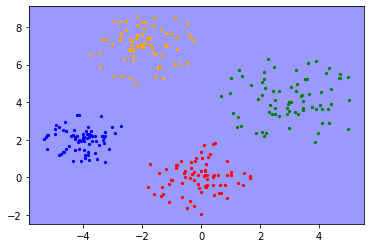

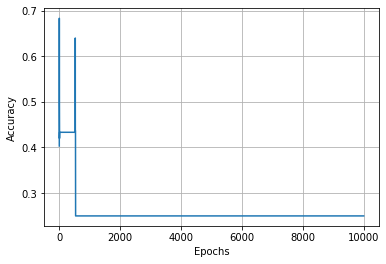

In [158]:
# 決定領域描画のための自作関数
plot(mlp, data, labels)
plt.show()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(len(mlp.acc_test)), mlp.acc_test)
plt.grid()
plt.show()

In [67]:
def load_data(filename):
    data = []
    labels = []
    with open(filename) as f:
        lines = f.readlines()
        h, w = lines[0].split(',')
        h, w = int(h), int(w)
        for l in lines[1:]:
            arr = l.split(',')
            labels.append(arr[0])
            data.append([float(v) for v in arr[1:]])
        data = np.array(data).reshape(-1, 1, h, w)
        labels = np.array(labels)
    return data, labels

data_train, labels_train = load_data('../data/mnist/mnist_train')
data_test, labels_test = load_data('../data/mnist/mnist_test')

# 時間がかかる場合はこちらの小さい方のデータを使う
data_train_s, labels_train_s = data_train[:5000], labels_train[:5000]
data_test_s, labels_test_s = data_test[:1000], labels_test[:1000]

In [79]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

np.seterr(all='raise')

#cnn = CNN(FN=30, FH=3, FW=3, PH=2, PW=2, h_units=100, h_layers=2, c_layers=2, epochs=20, eta=1e-1, n_batch=128, l2=0.,
#          stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)
cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, c_layers=1, epochs=20, eta=1e-1, n_batch=128, l2=1e-3,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

#cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Cost')
plt.plot(range(len(cnn.cost)), cnn.cost)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(len(cnn.mse_train)), cnn.mse_train, label='train')
plt.plot(range(len(cnn.mse_test)), cnn.mse_test, label='test')
plt.grid()
plt.legend()
plt.show()

pd.DataFrame([
    cnn.predict(data_test[:20]),
    labels_test[:20],
    cnn.predict(data_test[:20]) == labels_test[:20]
])

(128, 1, 28, 28) Affine


ValueError: could not broadcast input array from shape (128,1,28,28) into shape (128,1)

In [80]:
for l in cnn.layers:
    print(l.__class__.__name__)

Affine
BatchNormalization
ReLU
Affine
SoftMax


In [ ]:
# 犬猫画像読み込み
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

IMG_SIZE=128

def load_cats_and_dogs_images(img_dir):
    images_ = {'cat': [], 'dog': []}
    for img_file in os.listdir(path=img_dir):
        try:
            img = Image.open(img_dir + '/' + img_file).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            l = 'cat' if img_file[0].isupper() else 'dog'
            images_[l].append(np.asarray(img).transpose(2, 0, 1))
        except UnidentifiedImageError as e:
            print(e)
    for k, v in images_.items():
        print('{} {} images are loaded'.format(len(v), k))
    return images_

images = load_cats_and_dogs_images('../data/Oxford-IIIT-Pet-Dataset/images')